# Quickstart: Use Cases and Examples with *Open Bandit Pipeline*
---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy using some OPE estimators and logged bandit feedback generated by running the Random policy (behavior policy) on the ZOZOTOWN platform.

Our example with Open Bandit Dataset (OBD) contains the following three major steps:
- (1) Data Loading and Preprocessing
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation

In [1]:
from pathlib import Path
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
import obp
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.3.3


## (1) Data Loading and Preprocessing

We prepare easy-to-use data loader for Open Bandit Dataset, `OpenBanditDataset` class in the dataset module. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [3]:
# (1) Data loading and preprocessing
# specify path of dataset
data_path = Path('.').resolve().parents[1] / 'obd'
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
dataset = OpenBanditDataset(behavior_policy='random', campaign='all', data_path=data_path)
# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'reward_test', 'pscore', 'context', 'action_context'])

### let's see some properties of the dataset class

In [4]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [5]:
# number of actions of the "All" campaign is 80
dataset.n_actions

80

In [6]:
# small sample example data has 10,000 rounds
dataset.n_rounds

10000

In [7]:
# default context (feature) engineering creates context vector with 20 dimensions
dataset.dim_context

20

In [8]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

## (2) Off-Policy Learning

After preparing the dataset, we now run **off-policy learning**.

Here, we use **Bernoulli TS** implemented in the policy module as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate BernoulliTS used in ZOZOTOWN production.
(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

In [9]:
# (2) Off-Policy Learning
# define evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list, 
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)
# compute the action choice probabilities by the evaluation policy using Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

# action_dist is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the evaluation policy
action_dist

array([[[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       ...,

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
  

## (3) Off-Policy Evaluation (OPE)

Our final step is **off-policy evaluation**, which attempts to estimate the performance of new decision making policies using log data generated by behavior, past policies. 

We use the *InverseProbabilityWeighting (IPW)*, *DirectMethod (DM)*, and *Doubly Robust (DR)* estimators and estimate the performance of Bernoulli TS using the logged bandit feedback. 

Finally, we summarize and visualize the OPE results.

In [10]:
# estimate the mean reward function by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LogisticRegression(random_state=12345),
)
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [11]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure.
    random_state=12345,
)

In [12]:
# ground-truth policy value of the random policy
# , which is the empirical mean of the factual (observed) rewards (on-policy estimation)
ground_truth = bandit_feedback['reward'].mean()

# calculate estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value['relative_estimated_policy_value'] =\
        estimated_policy_value.estimated_policy_value / ground_truth

In [13]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004553,1.198126
dm,0.003399,0.894428
dr,0.004647,1.222801


In [14]:
# estimated confidence intervals of policy value of BernoulliTS by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure 
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004544,0.001531,0.009254
dm,0.003399,0.003351,0.003447
dr,0.004637,0.001621,0.009321


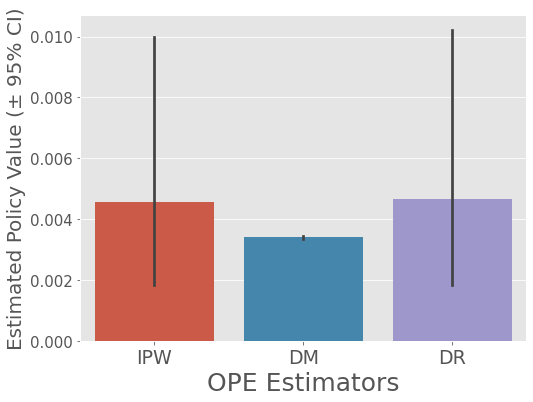

In [15]:
# visualize the estimated policy values of BernoulliTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    random_state=12345,
)

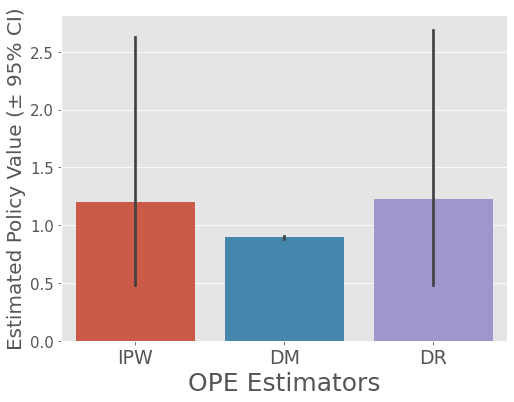

In [16]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 

Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.